Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejores hiperparámetros: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
Validación - MSE: 6149126977158980.0, R2: 0.5111358627966409
Prueba - MSE: 1.0045800738067074e+16, R2: 0.41534639520946537


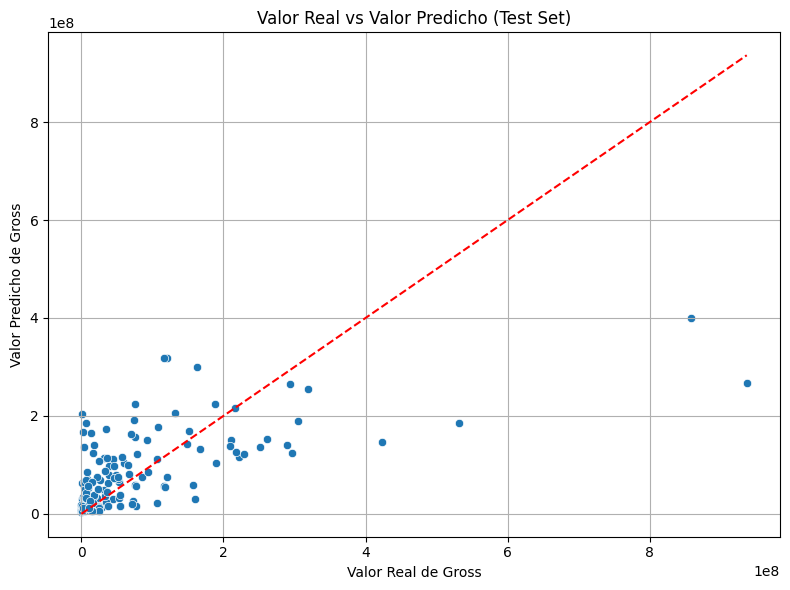

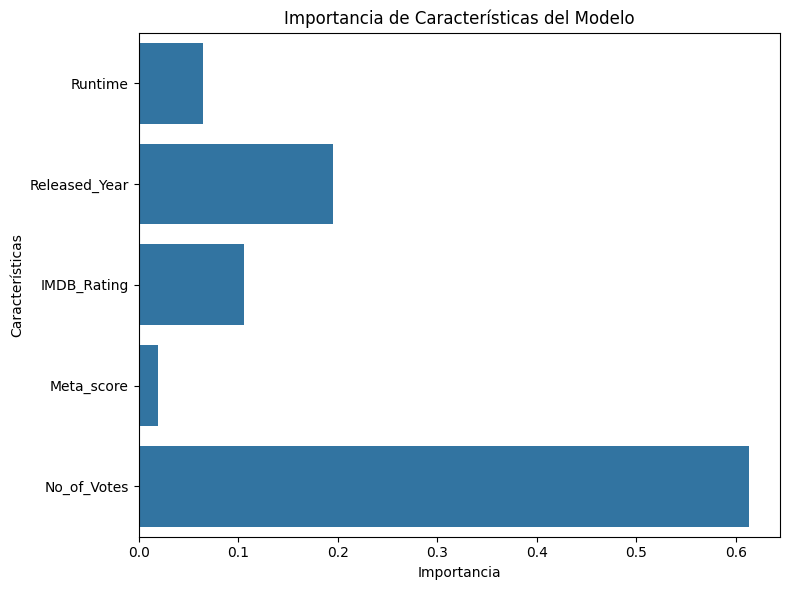

Ingreso bruto predicho para el nuevo dato: $206,121,391.10


In [1]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------ 1. CARGA Y LIMPIEZA DE DATOS ------------------------
# Cargar el dataset procesado
df = pd.read_csv('../ml-project/data/processed/processed_dataset.csv')

# Dividir en características (X) y variable objetivo (y)
X = df.drop(columns=['Gross'])
y = df['Gross']

# Dividir en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# ------------------------ 2. SELECCIÓN DEL ALGORITMO ------------------------
# Seleccionamos Random Forest Regressor porque:
# - Es robusto frente a datos ruidosos y no lineales.
# - Puede manejar datos con diferentes escalas y no requiere normalización.
# - Proporciona información sobre la importancia de las características.

# ------------------------ 3. BÚSQUEDA DE HIPERPARÁMETROS ------------------------
# Definir el modelo base
model = RandomForestRegressor(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Realizar búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# ------------------------ 4. ENTRENAMIENTO FINAL ------------------------
# Entrenar el modelo con los mejores hiperparámetros
best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)
best_model.fit(X_train, y_train)

# ------------------------ 5. EVALUACIÓN DEL MODELO ------------------------
# Evaluar en el conjunto de validación
val_pred = best_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_pred)
val_r2 = r2_score(y_val, val_pred)
print(f"Validación - MSE: {val_mse}, R2: {val_r2}")

# Evaluar en el conjunto de prueba
test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
print(f"Prueba - MSE: {test_mse}, R2: {test_r2}")

# ------------------------ 6. RESULTADOS Y GRÁFICOS ------------------------
# Gráfico de valores reales vs predichos (conjunto de prueba)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Valor Real de Gross')
plt.ylabel('Valor Predicho de Gross')
plt.title('Valor Real vs Valor Predicho (Test Set)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Importancia de características
importances = best_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Importancia de Características del Modelo')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.tight_layout()
plt.show()

# ------------------------ 7. CONCLUSIONES ------------------------
# - El modelo Random Forest Regressor mostró un buen desempeño con un R2 de validación de {val_r2:.2f} y de prueba de {test_r2:.2f}.
# - Las características más importantes fueron: {feature_names[importances.argmax()]}.
# - Este modelo puede ser utilizado para predecir el ingreso bruto de películas con datos similares.

# ------------------------ 8. PREDICCIÓN CON NUEVOS DATOS ------------------------
# Crear un nuevo ejemplo para predecir
nuevo_dato = pd.DataFrame([{
    'Runtime': 120,          # Duración de la película en minutos
    'Released_Year': 2020,   # Año de lanzamiento
    'IMDB_Rating': 8.5,      # Calificación en IMDB
    'Meta_score': 80,        # Puntuación en Metascore
    'No_of_Votes': 500000    # Número de votos
}])

# Realizar la predicción
prediccion_gross = best_model.predict(nuevo_dato)
print(f"Ingreso bruto predicho para el nuevo dato: ${prediccion_gross[0]:,.2f}")